In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
# Save figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = 'cnn'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [16]:
# Function to deal with the figures, plot grayscale and RGB images:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

# What is convolution

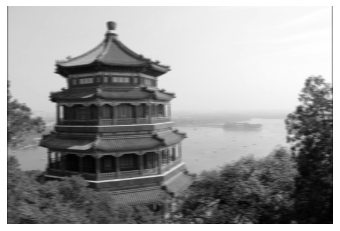

In [4]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255    # (427, 640, 3)
flower = load_sample_image("flower.jpg") / 255  # (427, 640, 3)
images = np.array([china, flower])              # (2, 427, 640, 3)
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)  # (7,7,3,2)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

0 0


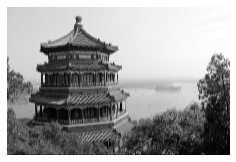

0 1


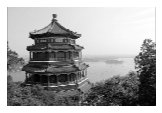

1 0


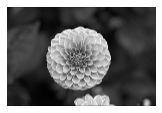

1 1


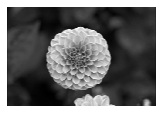

In [5]:
plt.figure(figsize=(10,6))
for image_index in (0,1):
    for feature_map_index in (0,1):
        print(image_index,feature_map_index)
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

0


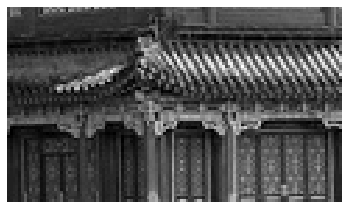

1


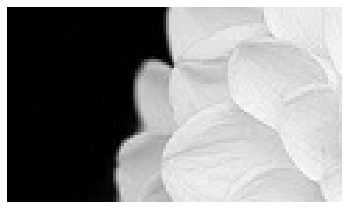

In [7]:
for j in (0,1):
    print(j)
    plot_image(crop(images[j,:,:,0]))
    

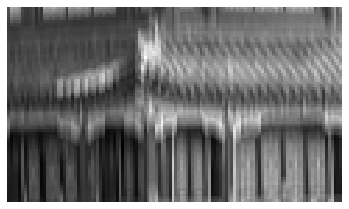

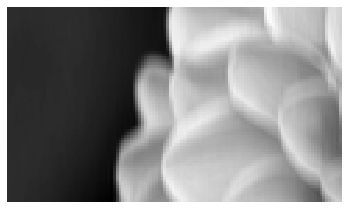

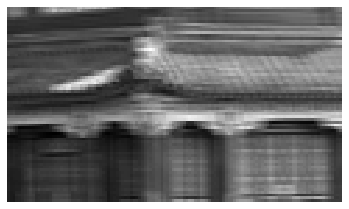

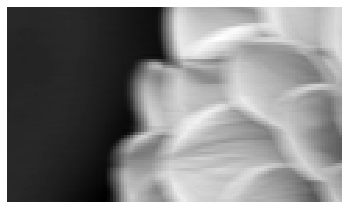

In [8]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plot_image(crop(outputs[1, :, :, feature_map_index]))
    #save_fig(filename, tight_layout=False)
    plt.show()

# Plot the filters

In [9]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)  # (7,7,3,2)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

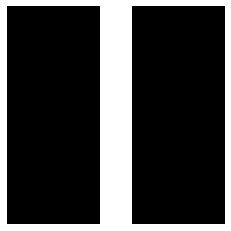

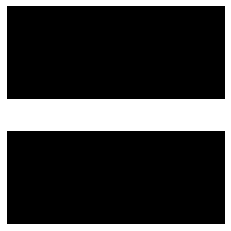

In [10]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()


# Convolutional layer

Create a 2D convolutional layer, using keras.layers.Conv2D()

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

# Define the Conv layer   (padding='same' with strides=1, the output has the same size as the input )
conv = keras.layers.Conv2D(filters=2,      # Dimensionality of the output space (no of output filters in the conv)
                           kernel_size=7,  # Specify the height and width of the 2D Conv window
                           strides=1,      # Specify the strides of the conv along the height and width
                           padding='SAME', # Results in padding with zeros evenly to the left/right or up/down of the input
                           activation='relu', input_shape=outputs.shape)


In [13]:
# To call the layer and pass it the two test images
conv_outputs = conv(images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [14]:
conv_outputs.shape

TensorShape([2, 427, 640, 2])

- The output is a 4D tensor, where the dimensions are batch_size, height, width and channels;
- batch_size = 2, since there are 2 input images;
- Since we have padding='same' and strides=1, the output feature maps have the same height and width as the inputs images.
- channels = 2, since there are 2 output features maps per input image



Since the filters are initialized randomly, they'll initially detect random patterns

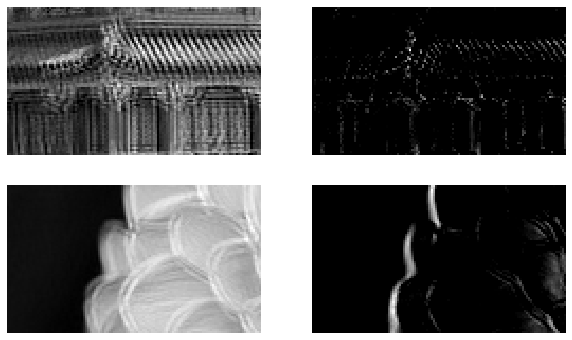

In [17]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

The second filter appears to act like an edge detector. The filters are randomly initialized often act this way, which is quite fortunate since detecting edges is quite useful in image processing

- If it is necessary, the filter can be set to be the ones that we manually defined earlier, and set the biases to zeros
- In practical, the filters almost never need a manual set of the filters and biases, since the convolutional layer will just learn the appropriate filters and biases during the training process

In [18]:
conv.set_weights([filters, np.zeros(2)])

In [19]:
# Let's call the layer in the input images again.
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

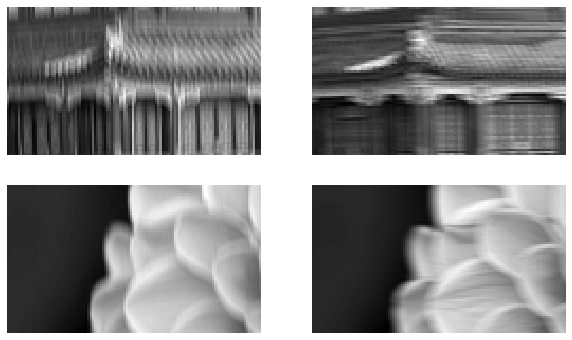

In [20]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

The output features maps highlight vertical and horizontal lines, respectively, as we have done before

# Pooling layer

Max Pooling

In [22]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

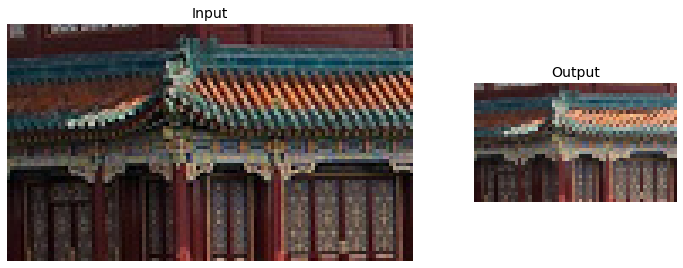

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
#save_fig("china_max_pooling")
plt.show()